# GenePy - a tutorial

In [1]:
import numpy as np
from genepy import genepy, examples
import matplotlib.pyplot as plt

##### Plotting configurations

In [2]:
plt.rcParams['font.size']       = 12
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['text.usetex']     = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
plt.rcParams['xtick.major.size'] = 8  # major X ticks
plt.rcParams['xtick.minor.size'] = 3  # minor X ticks
plt.rcParams['ytick.major.size'] = 8  # major Y ticks
plt.rcParams['ytick.minor.size'] = 3  # minor Y ticks

In [4]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

## Choose a test function

In [41]:
test_fn = examples.colville

In [42]:
x  = np.linspace(-10, 10, 200)
y  = np.linspace(-10, 10, 200)
xg, yg = np.meshgrid(x,y)
xy = np.column_stack([xg.ravel(), yg.ravel()])
z  = test_fn(xy).reshape(xg.shape)

ValueError: Inputs must be 4D vectors or arrays thereof.

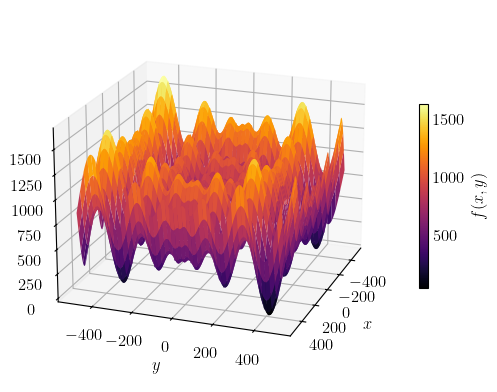

In [14]:
fig = plt.figure(figsize = (6,6))
ax  = fig.add_subplot(111, projection = '3d')
surf = ax.plot_surface(xg, yg, z, cmap = 'inferno')
ax.view_init(elev = 20, azim = 20)
cbar = fig.colorbar(surf, ax = ax, shrink = 0.4)
cbar.ax.tick_params(which = 'both', length=0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
cbar.set_label('$f(x,y)$')
plt.show()

## Preparing GA

In [43]:
def fitness(x):
    # fitness is always maximized
    return 1/(1 + test_fn(x))

In [28]:
optimum = 420.9687

In [44]:
decimals   = 3
n_var      = 4
var_ranges = np.array([[-10,]*n_var,[10,]*n_var])
n_bits_segment    = len(format(int(max(var_ranges[1] - var_ranges[0])*10**decimals), 'b'))
n_bits_chromosome = n_bits_segment * n_var
offset    = -var_ranges[0]

In [45]:
n_bits_segment, n_bits_chromosome

(15, 60)

In [46]:
PopGen = genepy.PopGenetics(
    fitness_func = fitness,
    n_var = n_var,
    decimal_acc = decimals,
    n_bits_chromosome = n_bits_chromosome,
)

### Initializing a population

In [47]:
init_popsize = 500

In [48]:
pop_bin = PopGen.initialize_population(
    popsize = init_popsize, 
    var_ranges = var_ranges, 
    return_genotype = True,
    offset = offset,
)
pop_bin.shape

(500, 60)

In [49]:
pop_dec = genepy.pop_bin2dec(
    pop_bin, 
    n_bits_segment, 
    decimal_acc = decimals, 
    offset = offset,
)
pop_dec.shape

(500, 4)

In [50]:
pop_fitness = fitness(pop_dec)
pop_fitness.shape

(500,)

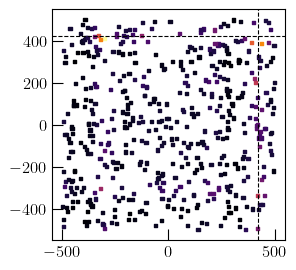

In [36]:
plt.figure(figsize = (3,3))
plt.scatter(
    pop_dec[:,0], 
    pop_dec[:,1], 
    # color = 'blue',
    marker = 's',
    s = 5,
    c = pop_fitness,
    cmap = 'inferno',
)
plt.axvline(optimum, color = 'k', ls = 'dashed', lw = 0.8)
plt.axhline(optimum, color = 'k', ls = 'dashed', lw = 0.8)
plt.show()

### Running evolution

In [51]:
n_gen    = 200 
n_pairs  = 800
n_elites = 3
switch_selection = 5
prob_mut = 0.05
pruning_cutoff = 800

In [52]:
evol_rec = PopGen.evolve(
    pop_bin, 
    n_gen    = n_gen, 
    n_pairs  = n_pairs,
    elitist  = True,
    n_elites = n_elites,
    liberal  = False,
    n_runts  = 0,
    switch_selection = switch_selection,
    prob_mut = prob_mut, 
    prune    = True,
    pruning_cutoff = pruning_cutoff,
    verbose  = True,
    n_workers = 1,
)


[genepy] Evolution in progress: 100%|██████████| 200/200 [00:56<00:00,  3.54gen/s]


In [53]:
evol_rec['fittest_individual'], evol_rec['best_overall_fitness']

(array([0.362, 0.605, 1.194, 1.519]), np.float64(59.06727873750609))

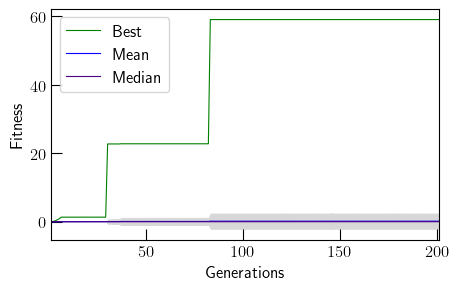

In [54]:
plt.figure(figsize = (5,3))
gens = np.arange(len(evol_rec['best_fitness_per_generation']))+1
plt.plot(gens, evol_rec['best_fitness_per_generation'], color = 'green', label = 'Best')
plt.plot(gens, evol_rec['mean_fitness_per_generation'], color = 'blue', label = 'Mean')
plt.plot(gens, evol_rec['median_fitness_per_generation'], color = 'indigo', label = 'Median')
plt.fill_between(
    gens,
    evol_rec['mean_fitness_per_generation'] - evol_rec['stdev_fitness_per_generation'], 
    evol_rec['mean_fitness_per_generation'] + evol_rec['stdev_fitness_per_generation'], 
    color = 'grey', 
    alpha = 0.3,
    lw = 0.0,
)
plt.legend()

# plt.ylim(0.99995, 1.00001)
# plt.ylim(0.9995, 1.0001)
# plt.ylim(0.995, 1.001)
# plt.ylim(0.8, 1.1)
plt.xlim(gens[0], gens[-1])

# plt.yscale('log')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()